 # Stock Price Prediction with LSTM(Long-Short-Term-Memory)
 

In [1]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
import yfinance as yf 
import pydot
import networkx


In [3]:
df = pd.DataFrame(yf.Ticker('ITUB4.SA').history(period = '5y'))
display(df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-23 00:00:00-02:00,23.549538,23.549538,23.247761,23.500156,4253100,0.0,0.0
2017-11-24 00:00:00-02:00,23.450770,23.533072,23.099611,23.280678,6183900,0.0,0.0
2017-11-27 00:00:00-02:00,23.099608,23.434307,23.017305,23.423332,9307200,0.0,0.0
2017-11-28 00:00:00-02:00,23.587936,23.774488,23.362975,23.461739,10623600,0.0,0.0
2017-11-29 00:00:00-02:00,23.620860,23.653780,22.978899,22.978899,16409400,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-16 00:00:00-03:00,26.650000,26.690001,26.010000,26.270000,44766100,0.0,0.0
2022-11-17 00:00:00-03:00,25.900000,26.440001,25.799999,26.430000,68496800,0.0,0.0
2022-11-18 00:00:00-03:00,26.690001,27.150000,26.389999,26.639999,49451800,0.0,0.0


In [4]:
print('DataFrame Info : ',df.info())
print('DataFrame Statistics : ',df.describe())
print('Null Value Present: ', df.isnull().values.any())
print('DataFrame Shape : ',df.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2017-11-23 00:00:00-02:00 to 2022-11-22 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1239 non-null   float64
 1   High          1239 non-null   float64
 2   Low           1239 non-null   float64
 3   Close         1239 non-null   float64
 4   Volume        1239 non-null   int64  
 5   Dividends     1239 non-null   float64
 6   Stock Splits  1239 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 109.7 KB
DataFrame Info :  None
DataFrame Statistics :                Open         High          Low        Close        Volume  \
count  1239.000000  1239.000000  1239.000000  1239.000000  1.239000e+03   
mean     27.271116    27.631276    26.896419    27.274136  3.051609e+07   
std       3.746030     3.741367     3.736849     3.666369  1.639349e+07   
min       0.000000     0.000000     0.000000    19.227480  0

<AxesSubplot:xlabel='Date'>

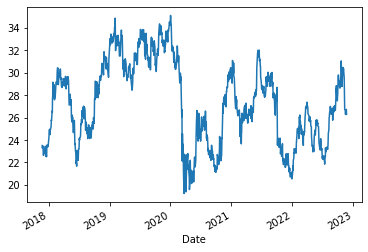

In [5]:
df['Close'].plot()

In [6]:
output_var = pd.DataFrame(df['Close'])
features = ['Open', 'High', 'Low', 'Volume','Dividends','Stock Splits']

In [7]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
display(feature_transform)


,Open,High,Low,Volume
Date,,,,
2017-11-23 00:00:00-02:00,0.679247,0.667326,0.672671,0.026471
2017-11-24 00:00:00-02:00,0.676398,0.666859,0.668384,0.038488
2017-11-27 00:00:00-02:00,0.666269,0.664060,0.666003,0.057927
2017-11-28 00:00:00-02:00,0.680354,0.673700,0.676005,0.066121
2017-11-29 00:00:00-02:00,0.681304,0.670280,0.664891,0.102131
...,...,...,...,...
2022-11-16 00:00:00-03:00,0.768674,0.756317,0.752596,0.278622
2022-11-17 00:00:00-03:00,0.747042,0.749233,0.746520,0.426320
2022-11-18 00:00:00-03:00,0.769828,0.769352,0.763591,0.307785


In [8]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [9]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])


In [11]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')




In [12]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)


Epoch 1/100
141/141 [==============================] - 2s 2ms/step - loss: 736.7176
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 583.5578
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 295.1212
Epoch 4/100
141/141 [==============================] - 0s 2ms/step - loss: 80.5593
Epoch 5/100
141/141 [==============================] - 0s 2ms/step - loss: 12.1333
Epoch 6/100
141/141 [==============================] - 0s 2ms/step - loss: 2.4597
Epoch 7/100
141/141 [==============================] - 0s 2ms/step - loss: 1.6187
Epoch 8/100
141/141 [==============================] - 0s 2ms/step - loss: 1.4931
Epoch 9/100
141/141 [==============================] - 0s 2ms/step - loss: 1.4294
Epoch 10/100
141/141 [==============================] - 0s 2ms/step - loss: 1.3692
Epoch 11/100
141/141 [==============================] - 0s 2ms/step - loss: 1.3023
Epoch 12/100
141/141 [==============================] - 0s 2ms/step - loss: 1.2344
Epoch

In [21]:
y_pred= lstm.predict(X_test)

4/4 [==============================] - 0s 2ms/step


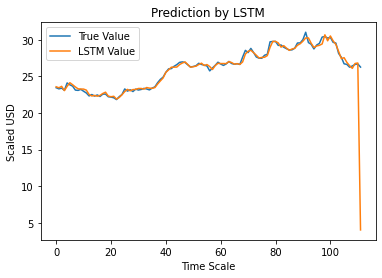

In [18]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()
